# End-to-End Multi-Class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

# 1. Problem 

Identifying the breed of a dog given the image of a dog.

When I'm sitting at the cafe and i take a photo of a dog, I want to know what breed of dog it is.

# 2. Data

The data we are using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data

# 3. Evaluation 

The evaluation is a file wih prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

# 4. Features

Some information about the data : 
* We are dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (so this means there 120 different breeds)
* There are 10,000+ images in the training set (these images have labels)
* There are 10,000+ images in the test set (these images have no labels, because we want to predict them)  

In [ ]:
#!unzip "drive/MyDrive/Dog vision/dog-breed-identification.zip" -d "drive/MyDrive/Dog vision/"

### Get our workspace ready

* Import TensorFlow 2.x ✅
* Import TensorFlow Hub ✅
* Make sure we are using a GPU ✅


In [38]:
# import necessary tools
import tensorflow as tf
import tensorflow_hub as hub 
print("TF version : ", tf.__version__)
print("TF Hub version : ", hub.__version__)

# Check for GPU availability
print("GPU", "available (YEEEEEEEESS!!!)" if tf.config.list_physical_devices("GPU") else "not available")

TF version :  2.7.0
TF Hub version :  0.12.0
GPU available (YEEEEEEEESS!!!)


## Getting our data ready (Turning into Tensors)

With all machine learning models, our data has to be in numerical format. So that's what we will be doing first. Turning our images into Tensors (numerical representations) 

Let's start by accessing our data and checking out labels.

In [39]:
# Check out the labels of our data
import pandas as pd
labels_csv = pd.read_csv("drive/MyDrive/Dog vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     6bb1f7a386fa0b9fcf94d4500686b0fd  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [40]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


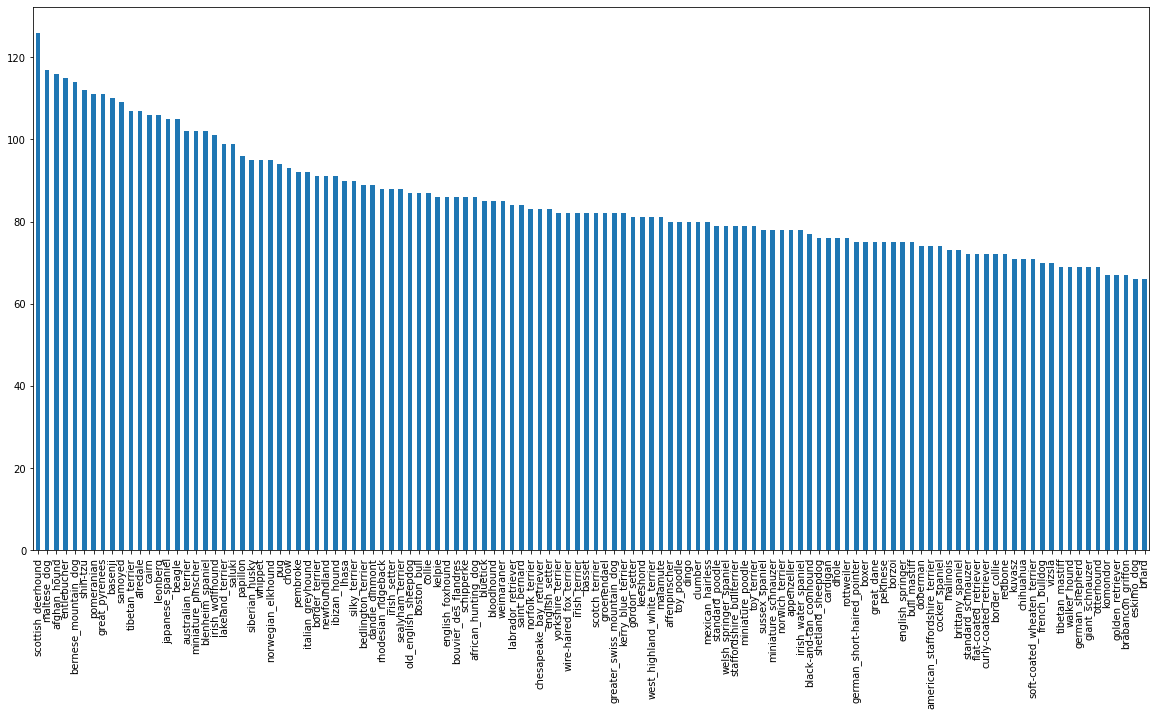

In [41]:
# How many images are there of each breed
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [42]:
labels_csv["breed"].value_counts().median()

82.0

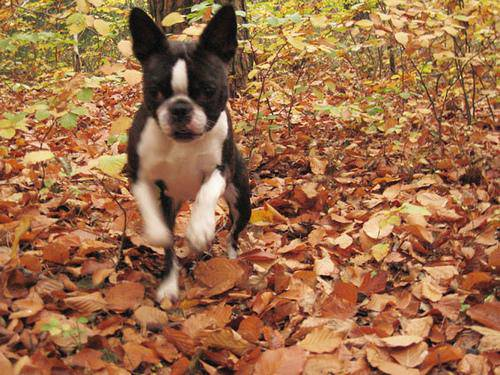

In [43]:
# Let's view a image
from IPython.display import Image

Image("drive/MyDrive/Dog vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

###Getting images and their labels

Let's get a list of all our image file pathnames.

In [44]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [45]:
# Create pathname from image ID's
filenames = ["drive/MyDrive/Dog vision/train/" + fname for fname in labels_csv["id"] + ".jpg"]

# check the first 10
filenames[:10]

['drive/MyDrive/Dog vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [46]:
# Check weither number of filenames matches number of actual image files

import os
if len(os.listdir("drive/MyDrive/Dog vision/train/")) == len(filenames):
  print("Filenames matches actual amount of files !! proceed.")
else: 
  print("Filenames do not match actual amount of files, check the target directory")

Filenames matches actual amount of files !! proceed.


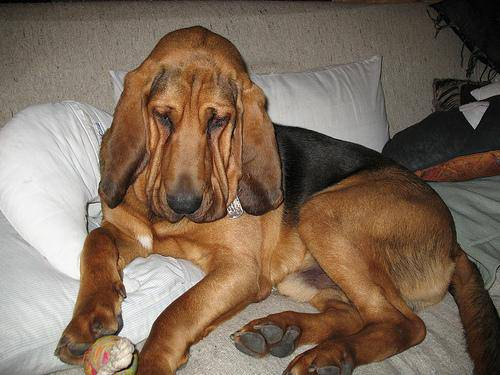

In [47]:
# One image
Image(filenames[69])

Since we have got our training image filepaths in a list, let's prepare our labels.

In [48]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
# same as :
#labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [49]:
len(labels)

10222

In [50]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames")
else: 
  print("Number of labels does not match number of filenames, check data directories")

Number of labels matches number of filenames


In [51]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [52]:
# Turn a single label into an array of booleans

print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [53]:
# turn every label into a boolean array

boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [54]:
len(boolean_labels)

10222

In [55]:
#Example: Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) #index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [56]:
print(labels[2]) 
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [57]:
filenames[:10]

['drive/MyDrive/Dog vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

### Creating our own validation set 

Since the dataset from Kaggle doesn't come with a validation set we will create one 

In [58]:
# Setup X & y variables 
X = filenames 
y = boolean_labels

We are going to start off experimenting with ~1000 images and increase as needed

In [59]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [60]:
#Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split


#Split them into training and validation of total size of NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size= 0.2,
                                                  random_state=42)
len(X_train), len(X_val), len(y_train), len(y_val)

(800, 200, 800, 200)

In [61]:
#Let's have a look at the training data
X_train[:5], y_train[:2]

(['drive/MyDrive/Dog vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/Dog vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/MyDrive/Dog vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/MyDrive/Dog vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/MyDrive/Dog vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, 

### Preprocessing images (Turning images into Tensors)

To process our images into Tensors we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Resize the image to be a shape of (224,224)
5. Return the modified image

In [62]:
# Convert image to Numpy Array
from matplotlib.pyplot import imread
image = imread(filenames[42])

image.shape

(257, 350, 3)

In [63]:
image.max(), image.min()

(255, 0)

In [64]:
#Turn image into a tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

Now we've seen what an image looks like as a Tensor, let's make a function to preprocess them.

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our image ( Convert the colour channel values from 0-255 to 0-1 values )
5. Resize the image to be a shape of (224,224)
6. Return the modified image

In [65]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, image_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor
  """
  # Read in an image file 
  image = tf.io.read_file(image_path)

  # Turn the jpeg image into numerical Tensor with 3 colour channels (Read, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)

  # Convert the colour channel values from 0-255 to 0-1 values ( This is called normalization)
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Resize the image to our desired value (224,224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

## Turning our data into batches

Why turn out data into batches ?

Let's say you are trying to process 10,000+ images in one fo ... they all might not fit in memory

So that's why we do about 32  images at a time ( you can manually adjust the batch size if need be)

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this (image, label)


In [81]:
# Create a simple function to return a tuple (image, label)

def get_image_label(image_path, label):
  """
  Takes an image path name and the associated label,
  process the image and returns a tuple of (image, label)
  """
  image = process_image(image_path)
  return image, label


In [82]:
# Demo of the above
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we have got a way to  turn our data into a tuples of Tensors in the form: `(image, label)`, let's make a function to turn all of our data `(
X,y)` into batches ! 

In [83]:
#Define the batche size, 32 is a good start
BATCH_SIZE = 32

#Create a function to turn data into batches

def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data= False):
  """
  Creates batches of data out of images (X) and labels (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels)
  """

  #If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches ...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) #only filepaths ( no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating Validation data batches ...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),# filepaths
                                              tf.constant(y)))# labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches ...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),# filepaths
                                              tf.constant(y)))# labels
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images                                          
    data = data.shuffle(buffer_size=len(X)) # we shuffle them all because buffer_size = len(X)
    
    # Create (image, label) tuples (this  also turns the image path into a preproccessed image)
    data = data.map(get_image_label)

    # Turn the training data
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [84]:
#Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches ...
Creating Validation data batches ...


In [85]:
# Check out different attribute of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))